# Data Preprocessing

The goal of this lab is to introduce you to data preprocessing techniques in order to make your data suitable for applying a learning algorithm.

## 1. Handling Missing Values

A common (and very unfortunate) data property is the ocurrence of missing and erroneous values in multiple features in our dataset.
Download the dataset and corresponding information from the <a href="http://www.cs.uni-potsdam.de/ml/teaching/ss15/ida/uebung02/abalone.csv">course website</a>.

To determine the age of a abalone snail you have to kill the snail and count the annual
rings. You are told to estimate the age of a snail on the basis of the following attributes:
1. type: male (0), female (1) and infant (2)
2. length in mm
3. width in mm
4. height in mm
5. total weight in grams
6. weight of the meat in grams
7. drained weight in grams
8. weight of the shell in grams
9. number of annual rings (number of rings +1, 5 yields age)

However, these data is incomplete. Missing values are marked with −1.

In [151]:
import pandas as pd

# load data 
df = pd.read_csv("http://www.cs.uni-potsdam.de/ml/teaching/ss15/ida/uebung02/abalone.csv")
df.columns=['type','length','width','height','total_weight','meat_weight','drained_weight','shell_weight','num_rings']
df.head()

,type,length,width,height,total_weight,meat_weight,drained_weight,shell_weight,num_rings
0,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,-1
1,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,2,-1.000,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,2,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


### Exercise 1.1

Compute the mean of all positive numbers of each numeric column and the counts of each category.

In [163]:
import numpy as np
# mark -1 as NaN
df_nan = df.replace({-1: np.nan}, inplace=False)


In [31]:
# counts for categories on dataset with -1 set to nan
df_nan['type'].value_counts()

0.0    1500
2.0    1310
1.0    1279
Name: type, dtype: int64

In [65]:
# counts for categories on dataset 
df['type'].value_counts()

 0    1500
 2    1310
 1    1279
-1      87
Name: type, dtype: int64

In [83]:
# means as dict ignoring -1 on a per column basis
means = dict()
cols = list(df.columns)[1:]
for col in cols:
    means[col] = df[df[col]>=0].sum()[col]/len(df[df[col]>=0])
for k,v in means.items():
    print(k+"-"+str(round(v,6)))

length-0.523692
width-0.407955
height-0.13961
total_weight-0.828843
meat_weight-0.359263
drained_weight-0.180249
shell_weight-0.238604
num_rings-9.921756


In [69]:
# Means also using -1 values. As expected, values are lower because
# -1 decreases column sum
df[list(df.columns)[1:]].mean()

length            0.478448
width             0.366148
height            0.105771
total_weight      0.782421
meat_weight       0.318576
drained_weight    0.149442
shell_weight      0.208351
num_rings         9.662835
dtype: float64

In [73]:
# Means without nans
means_nan = df_nan[list(df_nan.columns)[1:]].mean()
means_nan


length            0.523692
width             0.407955
height            0.139610
total_weight      0.828843
meat_weight       0.359263
drained_weight    0.180249
shell_weight      0.238604
num_rings         9.921756
dtype: float64

In [82]:
#fails bc trailing zero is removed by round but not by pd.df.mean()
all([round(means[col],6) == means_nan[col] for col in cols])
# Anyway, we see that mean() does not discard the whole row if one value in it is
# na, but examines every row individually.

False

### Exercise 1.2

Compute the median of all positive numbers of each numeric column.

In [84]:
# meadian of all numeric colums without nans
df_nan[list(df_nan.columns)[1:]].median()

length            0.54500
width             0.42500
height            0.14000
total_weight      0.80175
meat_weight       0.33600
drained_weight    0.17050
shell_weight      0.23350
num_rings         9.00000
dtype: float64

### Exercise 1.3

Handle the missing values in a way that you find suitable. Argue your choices.

In [91]:
#create empty dict
na_ratio = dict()
#for every column, compute the ratio of values vs nan
for col in df.columns:
    na_ratio[col] = len(df[df[col]< 0])/len(df[df[col]>= 0])*100
    
na_ratio
# Between 2 and 3 % of the values in each column are missing.

{'drained_weight': 2.6801081878534543,
 'height': 3.0602171767028628,
 'length': 3.0602171767028628,
 'meat_weight': 3.085657862256233,
 'num_rings': 2.4282560706401766,
 'shell_weight': 2.503681885125184,
 'total_weight': 2.6044226044226044,
 'type': 2.127659574468085,
 'width': 3.0602171767028628}

Populating the interactive namespace from numpy and matplotlib


0.0         AxesSubplot(0.1,0.559091;0.363636x0.340909)
1.0    AxesSubplot(0.536364,0.559091;0.363636x0.340909)
2.0             AxesSubplot(0.1,0.15;0.363636x0.340909)
dtype: object

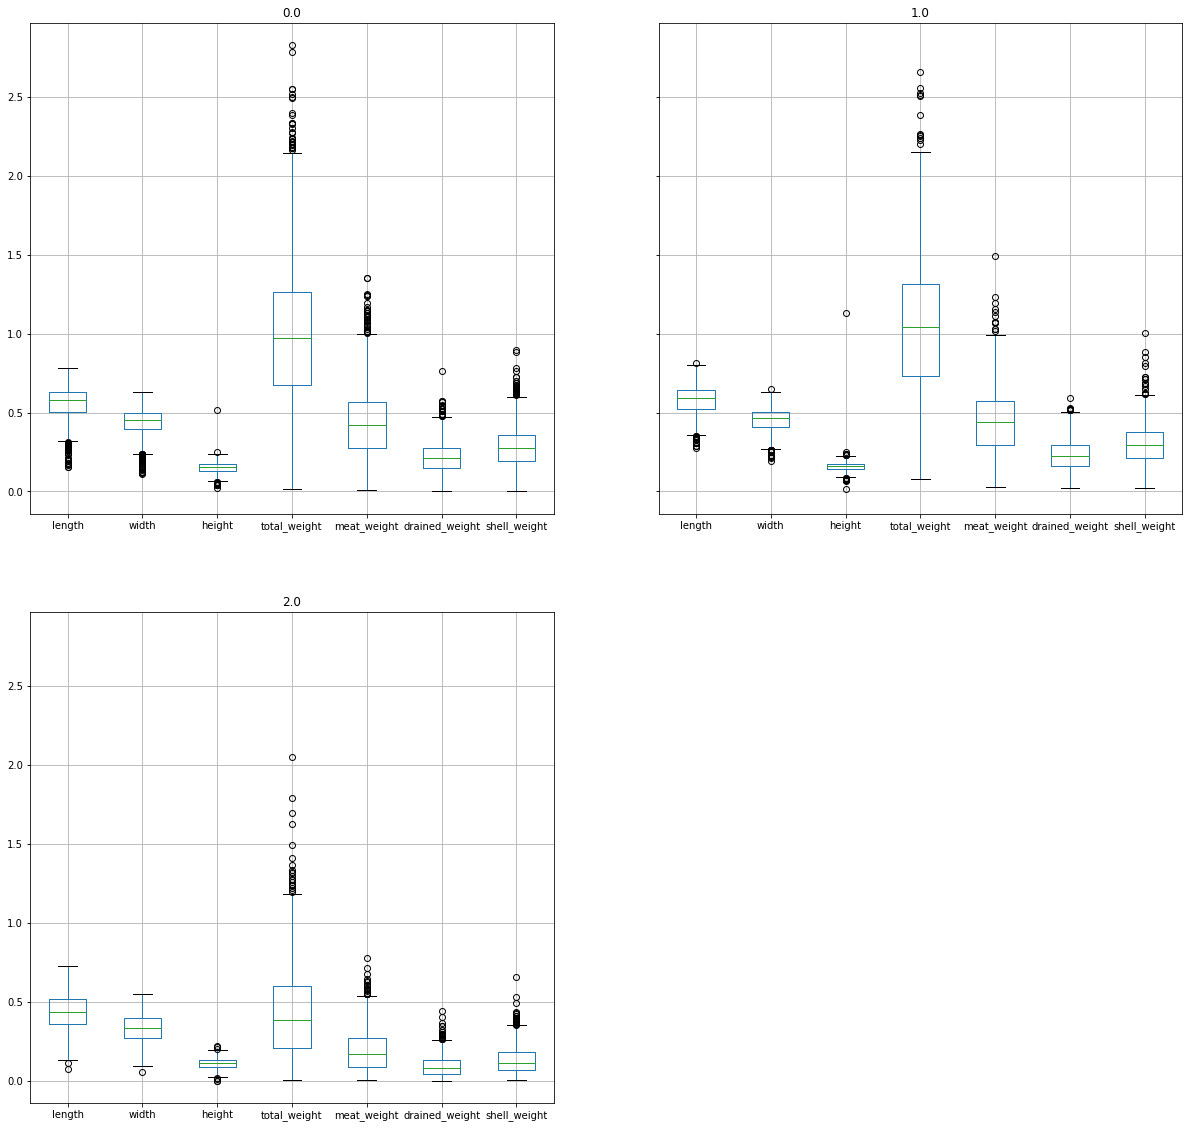

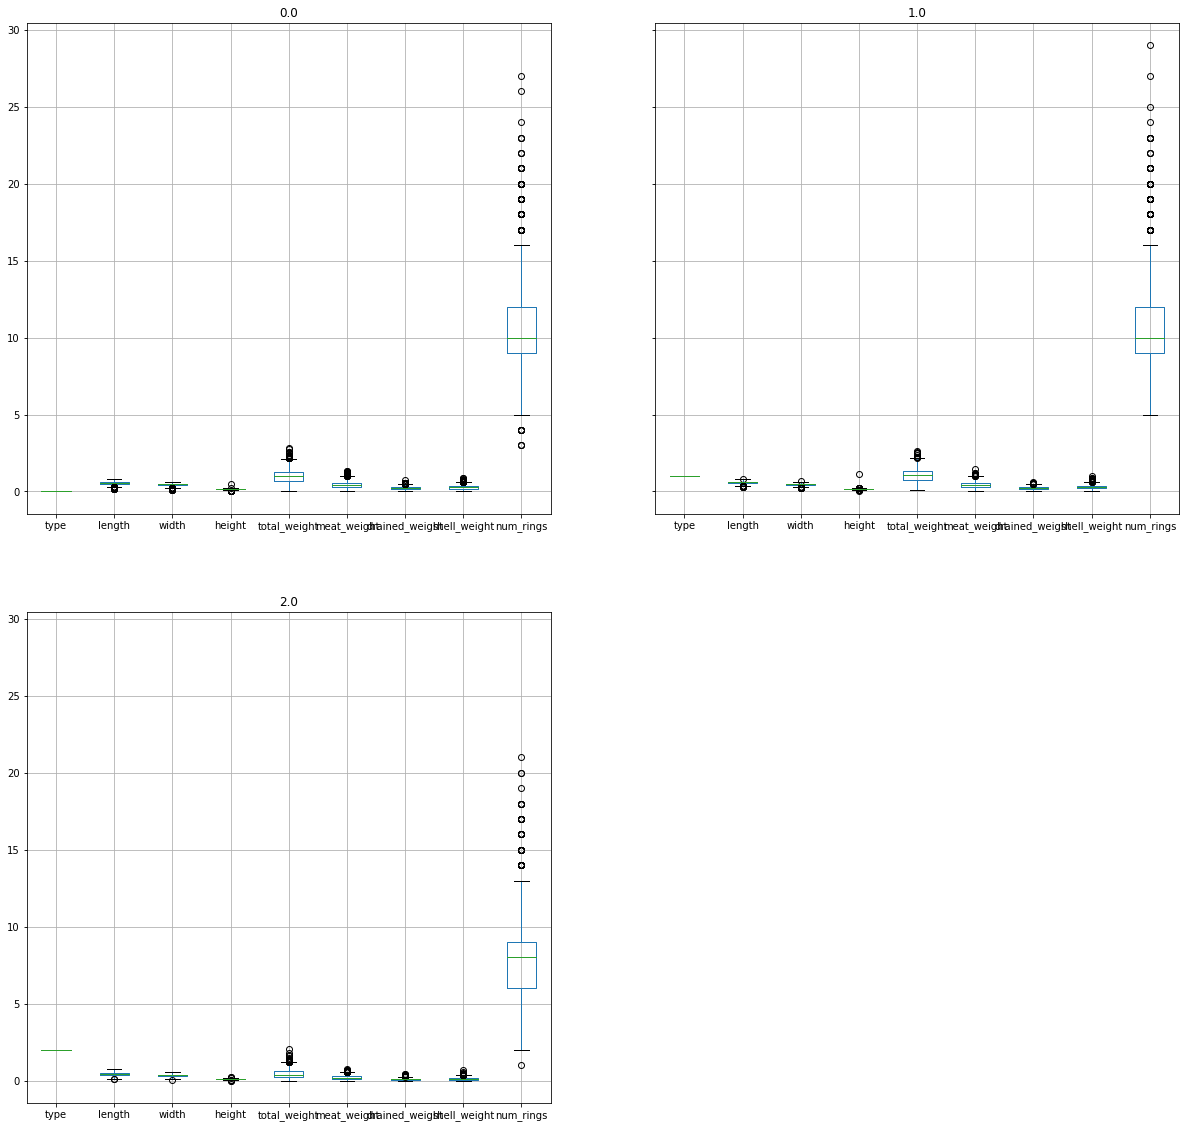

In [121]:
# We could simply decide that the portion of missing data is small enough to
# just be discarded without compromising the quality of our dataset.
# Or we pursue the following course of action. 
# 1. Group the data according to type. We can simply leave the type -1 as is and treat it 
# as another group or discard all rows with type == -1. 
# 2. We can now compute the mean/meadian for each
# group and substitute missing values with the mean for each respective group. The sample size is
# rather big, therefore the sample mean should be near the population mean. We simply assume that
# the data is distributed accordingly, but could as well test whether our assumption is correct. 
# We group the data because we assume that there is small intra and greater inter group variance
# We could check this as well. Additionally, we check each column for outliers. If there are heavy
# Outliers present, we use the median instead of the mean because the median is a more robust
# statistic.
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)
cols = df_nan.columns
# plot without rings bc scaling
df_nan[cols[1:-1]].groupby(df_nan['type']).boxplot()
# plot with rings because only rings does not work for some reason
#df_nan[cols[-1]].groupby(df_nan['type']).boxplot()
df_nan.groupby(df_nan['type']).boxplot()

In [170]:
# All have outliers, hence we use the median to fill in the gaps
#grouped = df_nan.groupby(df_nan['type'])#, as_index=False)
#grouped.median()
#df_nan.fillna(grouped.median())
#df.groupby("name").transform(lambda x: x.fillna(x.mean()))
#grouped.transform(lambda x: x.fillna(x.median()))
# The transform operation fails, because there is nas in the group vector as well..
df_nan2 = df[cols[2:]].replace({-1: np.nan}, inplace=False)
df_nan2 = pd.concat([df['type'], df_nan2], axis=1)
grouped2 = df_nan2.groupby(df_nan2['type'])
grouped2.median()
#



,width,height,total_weight,meat_weight,drained_weight,shell_weight,num_rings
type,,,,,,,
-1,0.405,0.135,0.71700,0.28800,0.15225,0.2115,9.0
0,0.455,0.155,0.97450,0.42150,0.21050,0.2760,10.0
1,0.465,0.160,1.04050,0.44200,0.22400,0.2950,10.0
2,0.335,0.110,0.38525,0.16875,0.08000,0.1130,8.0


In [184]:
# transform and replace nan with group median for each group
transformed = grouped2.transform(lambda x: x.fillna(x.median()))
# re add type
df_new = pd.concat([df['type'], transformed], axis =1)
# voila
df_new.head()

,type,width,height,total_weight,meat_weight,drained_weight,shell_weight,num_rings
0,0,0.265,0.090,0.2255,0.0995,0.0485,0.070,10.0
1,1,0.420,0.135,0.6770,0.2565,0.1415,0.210,9.0
2,0,0.365,0.125,0.5160,0.2155,0.1140,0.155,10.0
3,2,0.255,0.080,0.2050,0.0895,0.0395,0.055,7.0
4,2,0.300,0.095,0.3515,0.1410,0.0775,0.120,8.0


### Exercise 1.4

Perform Z-score normalization on every column (except the type of course!)

In [186]:
# Indicates how many standard deviations away from the mean the value is.
# If we replaced nan with mean instead of median the z score would be 0
# there because (mean - mean) / std = 0
zscore = lambda x: (x - x.mean()) / x.std()

z_trans = df_new.groupby(df['type'])[cols[2:]].transform(zscore)
z_trans.head()


,width,height,total_weight,meat_weight,drained_weight,shell_weight,num_rings
0,-2.084683,-1.801607,-1.638263,-1.508017,-1.613170,-1.631461,-0.235711
1,-0.501942,-0.587452,-0.879010,-0.977703,-0.925008,-0.741188,-0.681718
2,-0.890547,-0.780619,-1.016722,-0.983680,-0.979458,-0.976267,-0.235711
3,-0.827752,-0.895606,-0.799878,-0.791114,-0.843542,-0.868110,-0.355234
4,-0.310407,-0.418354,-0.285539,-0.386702,-0.233094,-0.097135,0.046282


## 2. Preprocessing text (Optional)

One possible way to transform text documents into vectors of numeric attributes is to use the TF-IDF representation. We will experiment with this representation using the 20 Newsgroup data set. The data set contains postings on 20 different topics. The classification problem is to decide which of the topics a posting falls into. Here, we will only consider postings about medicine and space.

In [188]:
from sklearn.datasets import fetch_20newsgroups

categories = ['sci.med', 'sci.space']
raw_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
print('The index of each category is: {}'.format([(i,target) for i,target in enumerate(raw_data.target_names)]))

The index of each category is: [(0, 'sci.med'), (1, 'sci.space')]


Check out some of the postings, might find some funny ones!

In [189]:
idx = np.random.randint(0, len(raw_data.data))
print('This is a {} email.\n'.format(raw_data.target_names[raw_data.target[idx]]))
print('There are {} emails.\n'.format(len(raw_data.data)))
print(raw_data.data[idx])

This is a sci.med email.

There are 1187 emails.

From: geb@cs.pitt.edu (Gordon Banks)
Subject: Re: Mississippi River water and catfish: safe?
Reply-To: geb@cs.pitt.edu (Gordon Banks)
Distribution: usa
Organization: Univ. of Pittsburgh Computer Science
Lines: 18

In article <1993Apr12.204033.126645@zeus.calpoly.edu> dfield@flute.calpoly.edu (InfoSpunj (Dan Field)) writes:
>I've been invited to spend a couple weeks this summer rafting down the
>Mississippi.  My journey partners want to live off of river water and
>catfish along the route.  Should I have any concerns about pollution or
>health risks in doing this?

You'd have to purify the river water first.  I'm not sure how practical
that is with the Mississippi.  You'd better check with health agencies
along the way to see if there are toxic chemicals in the river.  If
it is just microorganisms, those can be filtered or killed, but you
may need activated charcoal or other means to purify from chemicals.
Better be same than sorry.  Obv

Lets pick the first 10 postings from each category

In [190]:
idxs_med = np.flatnonzero(raw_data.target == 0)
idxs_space = np.flatnonzero(raw_data.target == 1)
idxs = np.concatenate([idxs_med[:10],idxs_space[:10]])
data = np.array(raw_data.data)
data = data[idxs]

<a href="http://www.nltk.org/">NLTK</a> is a toolkit for natural language processing. Take some time to install it and go through this <a href="http://www.slideshare.net/japerk/nltk-in-20-minutes">short tutorial/presentation</a>.

The downloaded package below is a tokenizer that divides a text into a list of sentences, by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences.

In [191]:
import nltk
import itertools
nltk.download('punkt')

# Tokenize the sentences into words
tokenized_sentences = [nltk.word_tokenize(sent) for sent in data]
vocabulary_size = 1000
unknown_token = 'unknown'

[nltk_data] Downloading package punkt to /home/kurt/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [192]:
# Count the word frequencies
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print("Found %d unique words tokens." % len(word_freq.items()))

Found 1641 unique words tokens.


In [193]:
# Get the most common words and build index_to_word and word_to_index vectors
vocab = word_freq.most_common(vocabulary_size-1)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])
 
print("Using vocabulary size %d." % vocabulary_size)
print("The least frequent word in our vocabulary is '%s' and appeared %d times." % (vocab[-1][0], vocab[-1][1]))

Using vocabulary size 1000.
The least frequent word in our vocabulary is 'REASONS' and appeared 1 times.


### Exercise 2.1

Code your own TF-IDF representation function and use it on this dataset. (Don't use code from libraries. Build your own function with Numpy/Pandas)

In [197]:
from sklearn.feature_extraction.text import CountVectorizer
countvec = CountVectorizer()
df = pd.DataFrame(countvec.fit_transform(data).toarray(), columns=countvec.get_feature_names())

def tfidf(df):
    pass
    '''
    Dont have time to code, but heres some of the basic steps
    1. For each document
    1.1 Split on space
    1.2 Strip interpunction and other stuff we dont need
    1.3 Get most common words
    1.4 Think of something smart to lets say count the plural or singular version of a word as the same (is this necessary?)
    1.5 Compute term frequency and inverse document frequency
    2. Put everything into a nice data frame where a row represents a document and the columns represent the words.
    '''
    
    #return rep

rep = tfidf(df)

# Check if your implementation is correct
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(norm=None, smooth_idf=False, use_idf=True)
X_train = pd.DataFrame(vectorizer.fit_transform(data).toarray(), columns=countvec.get_feature_names()
answer=['No','Yes']
if rep is not None:
    print('Is this implementation correct?\nAnswer: {}'.format(answer[1*np.all(X_train == rep)]))